# Import all the libraries required

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.dummy import DummyRegressor
from sklearn import preprocessing

# Load data

In [2]:
data2 = pd.read_csv('sales_data_2015_DF-inception-conv.csv')
data1 = pd.read_csv('sales_data_2015.csv')

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


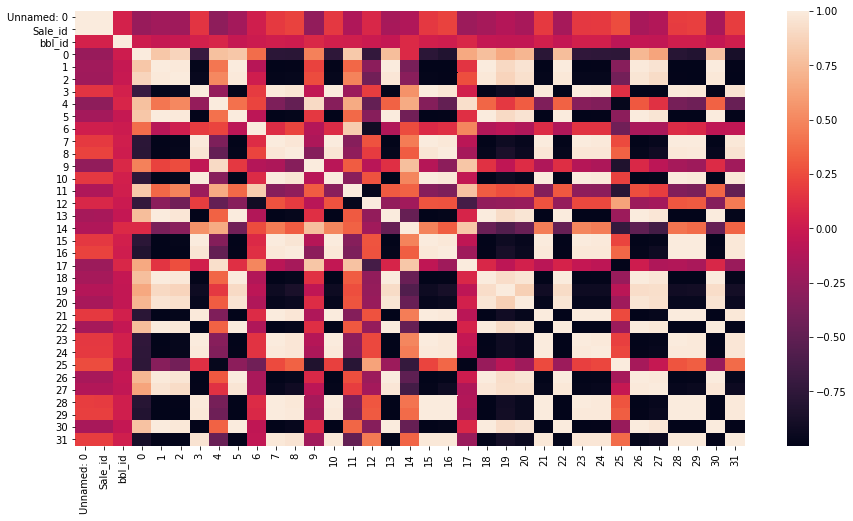

In [3]:
plt.figure(figsize=(15, 8))
sns.heatmap(data2.corr())

# Data preperation

In [4]:
# Define column to label 'keep' (default) or 'discard'
data1['prep']='keep'

In [5]:
# Column 'bbl_id' is not reliable since 222 entries have zero value
#data1['bbl_id'].value_counts()

In [6]:
# Alternative property ID is define based on definition of Department of Finance
# [The Department of Finance uses a Borough-Block-Lot classification to label all real property in the City. 
# “Whereas” addresses describe the street location of a property, 
# the block and lot distinguishes one unit of real property from another, 
# such as the different condominiums in a single building. 
# Also, block and lots are not subject to name changes based on which side of the parcel the building puts its entrance on.]
data1['prop_id']= data1[['borough','block','lot']].apply(lambda x: ','.join(x.astype(str)),axis=1)

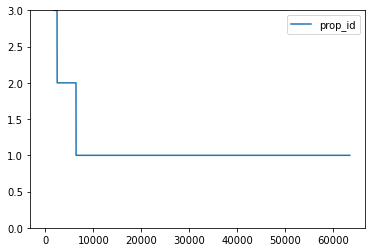

In [7]:
# New ID shows that about 60,000 properties where sold once in 2015
ax1=data1['prop_id'].value_counts().reset_index().plot(use_index=True)
ax1.set_ylim(0,3)
plt.show()

In [8]:
# Replace borough number by borougn names
borough_dict={1:'Manhattan',2:'The Bronx',3:'Brooklyn',4:'Queens',5:'Staten Island'} # source NYC OpenData
data1['borough']=data1['borough'].replace(borough_dict)

In [9]:
# Properties with more than 1 sale are removed, quality over quantity
prop_id_value_counts=data1['prop_id'].value_counts()
to_discard=prop_id_value_counts[prop_id_value_counts>1].index
data1.loc[data1.prop_id.isin(to_discard),'prep']='discard'

In [10]:
np.sum(data1['prep']=='discard')

27667

In [11]:
# Properties outlier of unlkely in terms of price
price_bounds_dict={'Manhattan':{'lower':100000,'upper':100000000},
                   'The Bronx':{'lower':20000,'upper':750000},
                   'Brooklyn':{'lower':150000,'upper':100000000},
                   'Queens':{'lower':125000,'upper':1000000},
                   'Staten Island':{'lower':200000,'upper':1000000}}

to_discard_on_price=set()
for index,row in data1.iterrows():
    if row['price']<price_bounds_dict[row['borough']]['lower']:
        to_discard_on_price.add(index)
    elif row['price']>price_bounds_dict[row['borough']]['upper']:
        to_discard_on_price.add(index)
    else:
        pass
    
data1.loc[to_discard_on_price,'prep']='discard'

In [12]:
np.sum(data1['prep']=='discard')

50128

In [13]:
# Replace entries with 'yr_built' of 0 to median of the zip code
data1[(data1['prep']=='keep') & (data1['yr_built']==0)].zip.unique()
for i in data1[(data1['prep']=='keep') & (data1['yr_built']==0)].zip.unique():
    data1.loc[data1.zip==i,'yr_built']=int(data1[(data1['prep']=='keep') & (data1['zip']==i)].yr_built.median())

In [14]:
# Discard entries with 'tot_sqft' of 0
data1.loc[data1.tot_sqft==0,'prep']='discard'

In [15]:
np.sum(data1['prep']=='discard')

63013

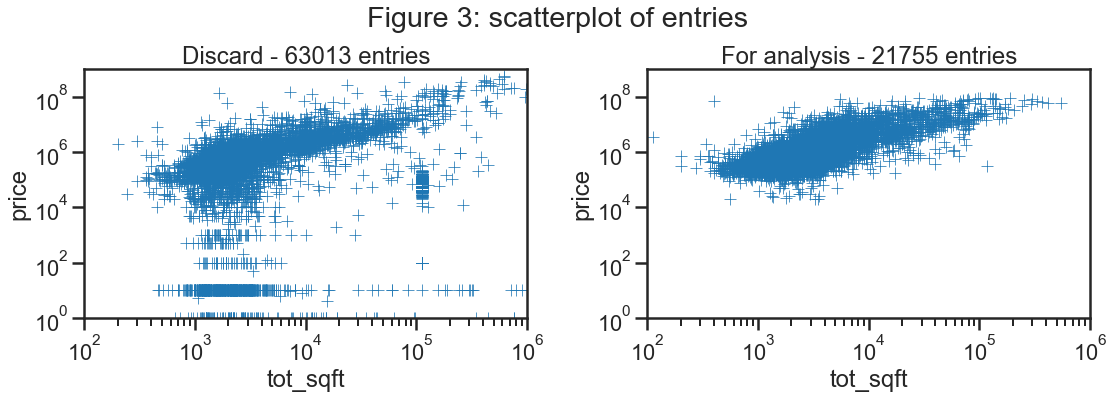

In [50]:
sns.set_style("ticks")
sns.set_context("poster")
f, ax = plt.subplots(1,2,figsize=(16, 6))
ax[1].set(xscale="log", yscale="log",ylim=(1,1000000000),xlim=(100, 1000000),
          title='For analysis - {} entries'.format(sum(data1['prep']=='keep')))
sns.scatterplot(data=data1[data1['prep']=='keep'],x='tot_sqft',y='price',marker="+", ax=ax[1])

ax[0].set(xscale="log", yscale="log",ylim=(1,1000000000),xlim=(100, 1000000),
          title='Discard - {} entries'.format(sum(data1['prep']=='discard')))
sns.scatterplot(data=data1[data1['prep']=='discard'],x='tot_sqft',y='price',marker="+", ax=ax[0])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle('Figure 3: scatterplot of entries')
plt.savefig("keep_discard.png")
plt.show()

In [17]:
# Drop rows
keep1=data1[data1['prep']=='keep']

# Merge extra features
keep=keep1.merge(data2.drop(['bbl_id','Unnamed: 0'],axis=1),how='inner',on='Sale_id')

# Drop columns
drop_columns=['Unnamed: 0','Sale_id','bbl_id','easmnt','usable','year','bldg_ctgy','bldg_cls_p','tax_cls_p',
              'block','lot','apt','zip','sale_date','long','lat','prep','address','prop_id']
keep.drop(columns=drop_columns,inplace=True)

In [18]:
#keep.info()

# Feature engineering

In [19]:
# categorial: borough, tax_cls, bldg_cls_s
# numeric: log(res_unit), log(com_unit), log(tot_unit),land_sqft,tot_sqft,yr_build
# price classes for RF

In [20]:
# Reduce number of categories for 'bldg_cl_s'
keep['bldg_cls_s']=keep['bldg_cls_s'].apply(lambda x: x[0])

In [21]:
# Set 'tax_cls_s' to string values
keep['tax_cls_s']=keep['tax_cls_s'].apply(lambda x: str(x))

In [22]:
# One-hot encoding for categorial values
keep=pd.get_dummies(data=keep,drop_first=False)

In [23]:
# Standardize the data
#names = keep.columns
#scaler = preprocessing.StandardScaler()
#scaled_keep = scaler.fit_transform(keep)
#scaled_keep = pd.DataFrame(scaled_keep, columns=names)
scaled_keep=keep

In [24]:
# Select features
#selected_features1=['res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft', 'yr_built',
#       'price', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
#       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
#       '24', '25', '26', '27', '28', '29', '30', '31', 'borough_Brooklyn',
#       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island',
#       'borough_The Bronx', 'tax_cls_s_1', 'tax_cls_s_2', 
#       'tax_cls_s_4', 'bldg_cls_s_A', 'bldg_cls_s_B', 'bldg_cls_s_C',
#       'bldg_cls_s_D', 'bldg_cls_s_E', 'bldg_cls_s_F', 'bldg_cls_s_G',
#       'bldg_cls_s_H', 'bldg_cls_s_I', 'bldg_cls_s_J', 'bldg_cls_s_K',
#       'bldg_cls_s_L', 'bldg_cls_s_M', 'bldg_cls_s_N', 'bldg_cls_s_O',
#       'bldg_cls_s_P', 'bldg_cls_s_Q', 'bldg_cls_s_R', 'bldg_cls_s_S',
#       'bldg_cls_s_T', 'bldg_cls_s_U', 'bldg_cls_s_V', 'bldg_cls_s_W',
#       'bldg_cls_s_Z']

selected_features1=['tot_sqft','price']
selected_features2=['borough_Brooklyn','borough_Manhattan','land_sqft','yr_built',
                    'borough_The Bronx', 'tot_sqft','price','tax_cls_s_4']
selected_features3=selected_features1+['0','4','6','9','11','17']
selected_features4=selected_features2+['0','4','6','9','11','17']

selected_keep1=scaled_keep[selected_features1]
selected_keep2=scaled_keep[selected_features2]
selected_keep3=scaled_keep[selected_features3]
selected_keep4=scaled_keep[selected_features4]

In [25]:
#selected_keep2.info()

# Data splitting

In [26]:
r_state=44

In [27]:
# Split train for val/test (rest)
X1=selected_keep1.drop('price', axis = 1)
y1=selected_keep1['price']
X1_train, X1_rest, y1_train, y1_rest = train_test_split(X1, y1, test_size=0.2, random_state=r_state)

# Split val and test for val/test (rest)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_rest, y1_rest, test_size=0.5, random_state=r_state)

In [28]:
# Split train for val/test (rest)
X2=selected_keep2.drop('price', axis = 1)
y2=selected_keep2['price']
X2_train, X2_rest, y2_train, y2_rest = train_test_split(X2, y2, test_size=0.2, random_state=r_state)

# Split val and test for val/test (rest)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_rest, y2_rest, test_size=0.5, random_state=r_state)

In [29]:
# Split train for val/test (rest)
X3=selected_keep3.drop('price', axis = 1)
y3=selected_keep3['price']
X3_train, X3_rest, y3_train, y3_rest = train_test_split(X3, y3, test_size=0.2, random_state=r_state)

# Split val and test for val/test (rest)
X3_val, X3_test, y3_val, y3_test = train_test_split(X3_rest, y3_rest, test_size=0.5, random_state=r_state)

In [30]:
# Split train for val/test (rest)
X4=selected_keep4.drop('price', axis = 1)
y4=selected_keep4['price']
X4_train, X4_rest, y4_train, y4_rest = train_test_split(X4, y4, test_size=0.2, random_state=r_state)

# Split val and test for val/test (rest)
X4_val, X4_test, y4_val, y4_test = train_test_split(X4_rest, y4_rest, test_size=0.5, random_state=r_state)

# Modelling

In [31]:
# Baseline
lmb = DummyRegressor(strategy='mean')
lmb.fit(X1_train, y1_train)
print('Estimated intercept coefficient:', lmb.constant_)

Estimated intercept coefficient: [[1455252.19853746]]


In [32]:
# Linear model 1
lm1 = LinearRegression()
lm1.fit(X1_train, y1_train)
print('Estimated intercept coefficient:', lm1.intercept_)
print('Number of coefficients:', len(lm1.coef_))

Estimated intercept coefficient: 465837.91965225106
Number of coefficients: 1


In [33]:
#pd.DataFrame(list(zip(X1_train.columns, lm1.coef_)), columns = ['features', 'estimatedCoefficients'])

In [34]:
# Linear model 2
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
print('Estimated intercept coefficient:', lm2.intercept_)
print('Number of coefficients:', len(lm2.coef_))

Estimated intercept coefficient: -154927.5682133676
Number of coefficients: 7


In [35]:
# Linear model 3
lm3 = LinearRegression()
lm3.fit(X3_train, y3_train)
print('Estimated intercept coefficient:', lm3.intercept_)
print('Number of coefficients:', len(lm3.coef_))

Estimated intercept coefficient: 607353.6841870744
Number of coefficients: 7


In [36]:
# Linear model 4
lm4 = LinearRegression()
lm4.fit(X4_train, y4_train)
print('Estimated intercept coefficient:', lm4.intercept_)
print('Number of coefficients:', len(lm4.coef_))

Estimated intercept coefficient: 375236.5760829393
Number of coefficients: 13


# Results

In [37]:
print("Results on train set:")
#Baseline
print("BL:")
yb_pred = lmb.predict(X1_train)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_train, yb_pred))
print('Variance score: %.2f' % r2_score(y1_train, yb_pred))

# SQRT
print("SQRT:")
y1_pred = lm1.predict(X1_train)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_train, y1_pred))
print('Variance score: %.2f' % r2_score(y1_train, y1_pred))

# BEST
print("BEST:")
y2_pred = lm2.predict(X2_train)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y2_train, y2_pred))
print('Variance score: %.2f' % r2_score(y2_train, y2_pred))

# SQRT+
print("SQRT+:")
y3_pred = lm3.predict(X3_train)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y3_train, y3_pred))
print('Variance score: %.2f' % r2_score(y3_train, y3_pred))

# BEST+
print("BEST+:")
y4_pred = lm4.predict(X4_train)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y4_train, y4_pred))
print('Variance score: %.2f' % r2_score(y4_train, y4_pred))

Results on train set:
BL:
Mean absolute error: 1531346.76
Variance score: 0.00
SQRT:
Mean absolute error: 1004927.13
Variance score: 0.43
BEST:
Mean absolute error: 804386.39
Variance score: 0.57
SQRT+:
Mean absolute error: 1048136.74
Variance score: 0.44
BEST+:
Mean absolute error: 836307.27
Variance score: 0.57


In [38]:
print("Results on val set:")
#Baseline
print("BL:")
yb_pred = lmb.predict(X1_val)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_val, yb_pred))
print('Variance score: %.2f' % r2_score(y1_val, yb_pred))

# SQRT
print("SQRT:")
y1_pred = lm1.predict(X1_val)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_val, y1_pred))
print('Variance score: %.2f' % r2_score(y1_val, y1_pred))

# BEST
print("BEST:")
y2_pred = lm2.predict(X2_val)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y2_val, y2_pred))
print('Variance score: %.2f' % r2_score(y2_val, y2_pred))

# SQRT+
print("SQRT+:")
y3_pred = lm3.predict(X3_val)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y3_val, y3_pred))
print('Variance score: %.2f' % r2_score(y3_val, y3_pred))

# BEST+
print("BEST+:")
y4_pred = lm4.predict(X4_val)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y4_val, y4_pred))
print('Variance score: %.2f' % r2_score(y4_val, y4_pred))

Results on val set:
BL:
Mean absolute error: 1402972.38
Variance score: -0.00
SQRT:
Mean absolute error: 928217.51
Variance score: 0.45
BEST:
Mean absolute error: 736710.41
Variance score: 0.59
SQRT+:
Mean absolute error: 966656.92
Variance score: 0.45
BEST+:
Mean absolute error: 767490.95
Variance score: 0.59


In [39]:
print("Results on test set:")
#Baseline
print("BL:")
yb_pred = lmb.predict(X1_test)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_test, yb_pred))
print('Variance score: %.2f' % r2_score(y1_test, yb_pred))

# SQRT
print("SQRT:")
y1_pred = lm1.predict(X1_test)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y1_test, y1_pred))
print('Variance score: %.2f' % r2_score(y1_test, y1_pred))

# BEST
print("BEST:")
y2_pred = lm2.predict(X2_test)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y2_test, y2_pred))
print('Variance score: %.2f' % r2_score(y2_test, y2_pred))

# SQRT+
print("SQRT+:")
y3_pred = lm3.predict(X3_test)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y3_test, y3_pred))
print('Variance score: %.2f' % r2_score(y3_test, y3_pred))

# BEST+
print("BEST+:")
y4_pred = lm4.predict(X4_test)
print("Mean absolute error: %.2f"
      % mean_absolute_error(y4_test, y4_pred))
print('Variance score: %.2f' % r2_score(y4_test, y4_pred))

Results on test set:
BL:
Mean absolute error: 1463576.18
Variance score: -0.00
SQRT:
Mean absolute error: 967326.21
Variance score: 0.45
BEST:
Mean absolute error: 785071.57
Variance score: 0.59
SQRT+:
Mean absolute error: 1012165.65
Variance score: 0.46
BEST+:
Mean absolute error: 820618.10
Variance score: 0.59


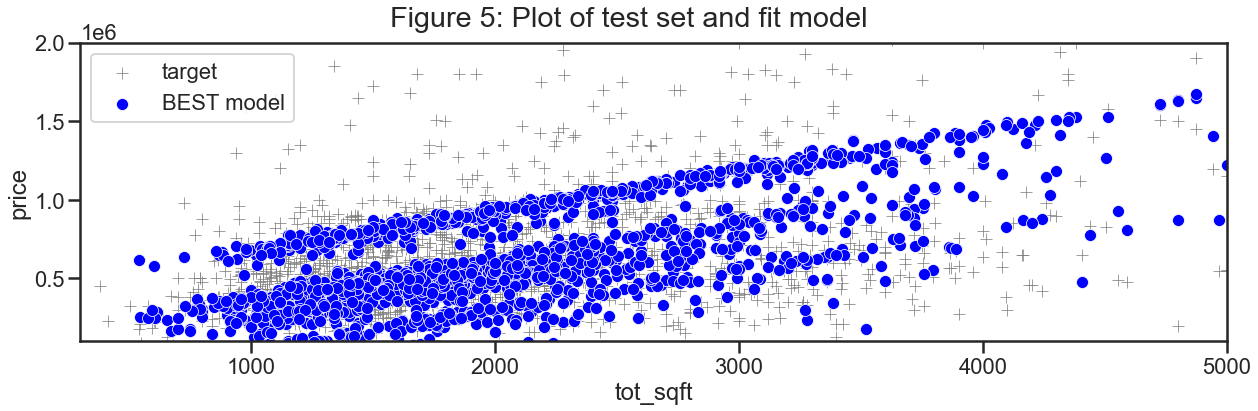

In [52]:
# Plot outputs
y2_pred = lm2.predict(X2_test)
sns.set_style("ticks")
sns.set_context("poster")
f, ax = plt.subplots(1,1,figsize=(18, 6))
ax.set(ylim=(100000,2000000),xlim=(300, 5000))
sns.scatterplot(x=X2_test['tot_sqft'],y=y2_test,marker="+",color='gray',label='target', ax=ax)
sns.scatterplot(x=X2_test['tot_sqft'],y=y2_pred,marker="o",color='blue',label='BEST model', ax=ax)
plt.tight_layout()
f.suptitle('Figure 5: Plot of test set and fit model')
plt.savefig("fit.png")
plt.show()